In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
from tqdm.auto import tqdm 


from nltk.corpus import stopwords 
import re 
from collections import Counter
from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix
from gensim import models

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM , Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
lb = LabelEncoder()

In [4]:
df = pd.read_csv('twitter_training.csv')

In [5]:
np.unique(df['Borderlands'])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [6]:
np.unique(df['Positive'])

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [7]:
df = df.drop('2401' , axis=1)

In [8]:
df= df.rename(columns={"Borderlands":"Feature2","im getting on borderlands and i will murder you all ,":"Feature1","Positive": "labels"})

In [9]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)
df['tweet_len'] = [len(text.split()) for text in df.tweets]
df = df[~(df['tweet_len'] < 5) & ~(df['tweet_len'] > 60)]

In [10]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [11]:
def getlabel(n) : 
    for x , y in df_labels.items() : 
        if y==n : 
            return x

In [12]:
def preprocess(txt) : 
    txt = txt.lower() 
    
    txt = re.sub("<br /><br />" , " " , txt) # replace line breaks
    
    txt = re.sub(r"(.)\1\1+" , r"\1\1" , txt)  # Replace 3 or more consecutive letters by 2 letter
    
    # replace all emojis
    txt = re.sub(r'<3', '<heart>' , txt) 
    txt = re.sub(r"[8:=;]['`\-]?[)d]+" , '<smile>' , txt)
    txt = re.sub(r"[8:=;]['`\-]?\(+" , '<sadface>' , txt) 
    txt = re.sub(r"[8:=;]['`\-]?[\/|l*]" , '<neutralface>' , txt) 
    txt = re.sub(r"[8:=;]['`\-]?p+" , '<lolface>' , txt)
    
    txt = re.sub(r"[^a-z0-9<>]" , ' ' , txt) # # Remove non-alphanumeric and symbols
    
    # Adding space on either side of '/' to seperate words (After replacing URLS). 
    txt = re.sub(r'/' , ' / ' , txt)
    
    txt = re.sub('<.*?>', '', txt) # HTML tags
    txt = re.sub(r'\d+', '', txt) # numbers
    txt = re.sub(r'[^\w\s]', '', txt) # special characters
    txt = re.sub(r'http\S+', '', txt) # URLs or web links
    txt = re.sub(r'@\S+', '', txt) # mentions
    txt = re.sub(r'#\S+', '', txt) # hashtags
    
    return txt

In [13]:
df['tweets'] = df.tweets.apply(preprocess)
df.head()

,labels,tweets,tweet_len
0,Positive,i am coming to the borders and i will kill you...,13
1,Positive,im getting on borderlands and i will kill you ...,11
2,Positive,im coming on borderlands and i will murder you...,11
3,Positive,im getting on borderlands and i will murder y...,13
4,Positive,im getting into borderlands and i can murder y...,11


In [14]:
df["tweets"].duplicated().sum()

2323

In [15]:
df.drop_duplicates("tweets", inplace=True)

In [16]:
labels = lb.fit_transform(df['labels'].values)
np.unique(labels)

array([0, 1, 2, 3])

In [17]:
x_train , x_val , y_train , y_val = train_test_split(df['tweets'] , labels , train_size = 0.80 , random_state = 42)

In [18]:
corpus = [word for txt in df['tweets'] for word in txt.split()]
words_count = Counter(corpus)
sorted_words = words_count.most_common()
# define parameters 
VOCAB_SIZE = len(sorted_words) 
EMBEDDING_DIM = 256
MAXLEN = np.max(df['tweet_len'])
tokenizer = Tokenizer(num_words = VOCAB_SIZE , oov_token='<OOV>')
tokenizer.fit_on_texts(df['tweets'].values)

In [19]:
# Word2Vec
Word2vec_train_data = list(map(lambda x:x.split() , list(x_train)))

In [20]:
word2vec_model = models.Word2Vec(Word2vec_train_data , vector_size = EMBEDDING_DIM)
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 12542


In [21]:
embedding_matrix = np.zeros((VOCAB_SIZE , EMBEDDING_DIM)) 
for word , token in tokenizer.word_index.items() : 
    if word2vec_model.wv.__contains__(word) : 
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
        
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (28508, 256)


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train) , maxlen=MAXLEN , padding = 'post')
x_val = pad_sequences(tokenizer.texts_to_sequences(x_val) , maxlen=MAXLEN , padding = 'post')
x_train.shape , x_val.shape

((51538, 60), (12885, 60))

In [23]:
print(f'Shape before one-hot encoding : {y_train.shape}')
y_train = tf.keras.utils.to_categorical(y_train , len(np.unique(labels)))
y_val = tf.keras.utils.to_categorical(y_val , len(np.unique(labels))) 
print(f'Shape after one-hot encoding : {y_train.shape}')

Shape before one-hot encoding : (51538,)
Shape after one-hot encoding : (51538, 4)


In [24]:
model = Sequential([
    Embedding(
        input_dim = VOCAB_SIZE , 
        output_dim= EMBEDDING_DIM , 
        weights = [embedding_matrix] , 
        input_length = MAXLEN ,
        trainable=False
    ) , 
    Bidirectional(LSTM(256 , return_sequences=True)) , 
    Bidirectional(LSTM(128)) , 
    Dense(64 , activation='relu') , 
    Dropout(0.5) , 
    Dense(4 , activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 256)           7298048   
                                                                 
 bidirectional (Bidirection  (None, 60, 512)           1050624   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [25]:
model.compile(optimizer=Adam(0.001) , loss='categorical_crossentropy' , metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])
history = model.fit(
    x_train , 
    y_train , 
    batch_size=128 , 
    epochs=10 , 
    validation_data = (x_val , y_val)
)

Epoch 1/10
403/403 [==============================] - 1979s 5s/step - loss: 1.0652 - accuracy: 0.5562 - precision: 0.6963 - recall: 0.3458 - val_loss: 0.9380 - val_accuracy: 0.6068 - val_precision: 0.7288 - val_recall: 0.4480
Epoch 2/10
403/403 [==============================] - 564s 1s/step - loss: 0.8988 - accuracy: 0.6355 - precision: 0.7435 - recall: 0.4864 - val_loss: 0.8023 - val_accuracy: 0.6770 - val_precision: 0.7692 - val_recall: 0.5506
Epoch 3/10
403/403 [==============================] - 575s 1s/step - loss: 0.7328 - accuracy: 0.7099 - precision: 0.7885 - recall: 0.6076 - val_loss: 0.6805 - val_accuracy: 0.7314 - val_precision: 0.7985 - val_recall: 0.6466
Epoch 4/10
403/403 [==============================] - 566s 1s/step - loss: 0.5216 - accuracy: 0.8065 - precision: 0.8493 - recall: 0.7544 - val_loss: 0.5309 - val_accuracy: 0.8012 - val_precision: 0.8306 - val_recall: 0.7676
Epoch 5/10
403/403 [==============================] - 549s 1s/step - loss: 0.3255 - accuracy: 0.886

In [26]:
print(f"The training loss is : {history.history['loss'][-1]:0.2f}\n")
print(f"The training accuracy is : {(history.history['accuracy'][-1]*100):0.2f}%\n")
print(f"The training precision is : {history.history['precision'][-1]:0.2f}\n")
print(f"The training recall is : {history.history['recall'][-1]:0.2f}\n")
print(f"The validation loss is : {history.history['val_loss'][-1]:0.2f}\n")
print(f"The validation accuracy is : {(history.history['val_accuracy'][-1]*100):0.2f}%\n")
print(f"The validation precision is : {history.history['val_precision'][-1]:0.2f}\n")
print(f"The validation recall is : {history.history['val_recall'][-1]:0.2f}\n")

The training loss is : 0.07

The training accuracy is : 97.92%

The training precision is : 0.98

The training recall is : 0.98

The validation loss is : 0.46

The validation accuracy is : 88.61%

The validation precision is : 0.89

The validation recall is : 0.88



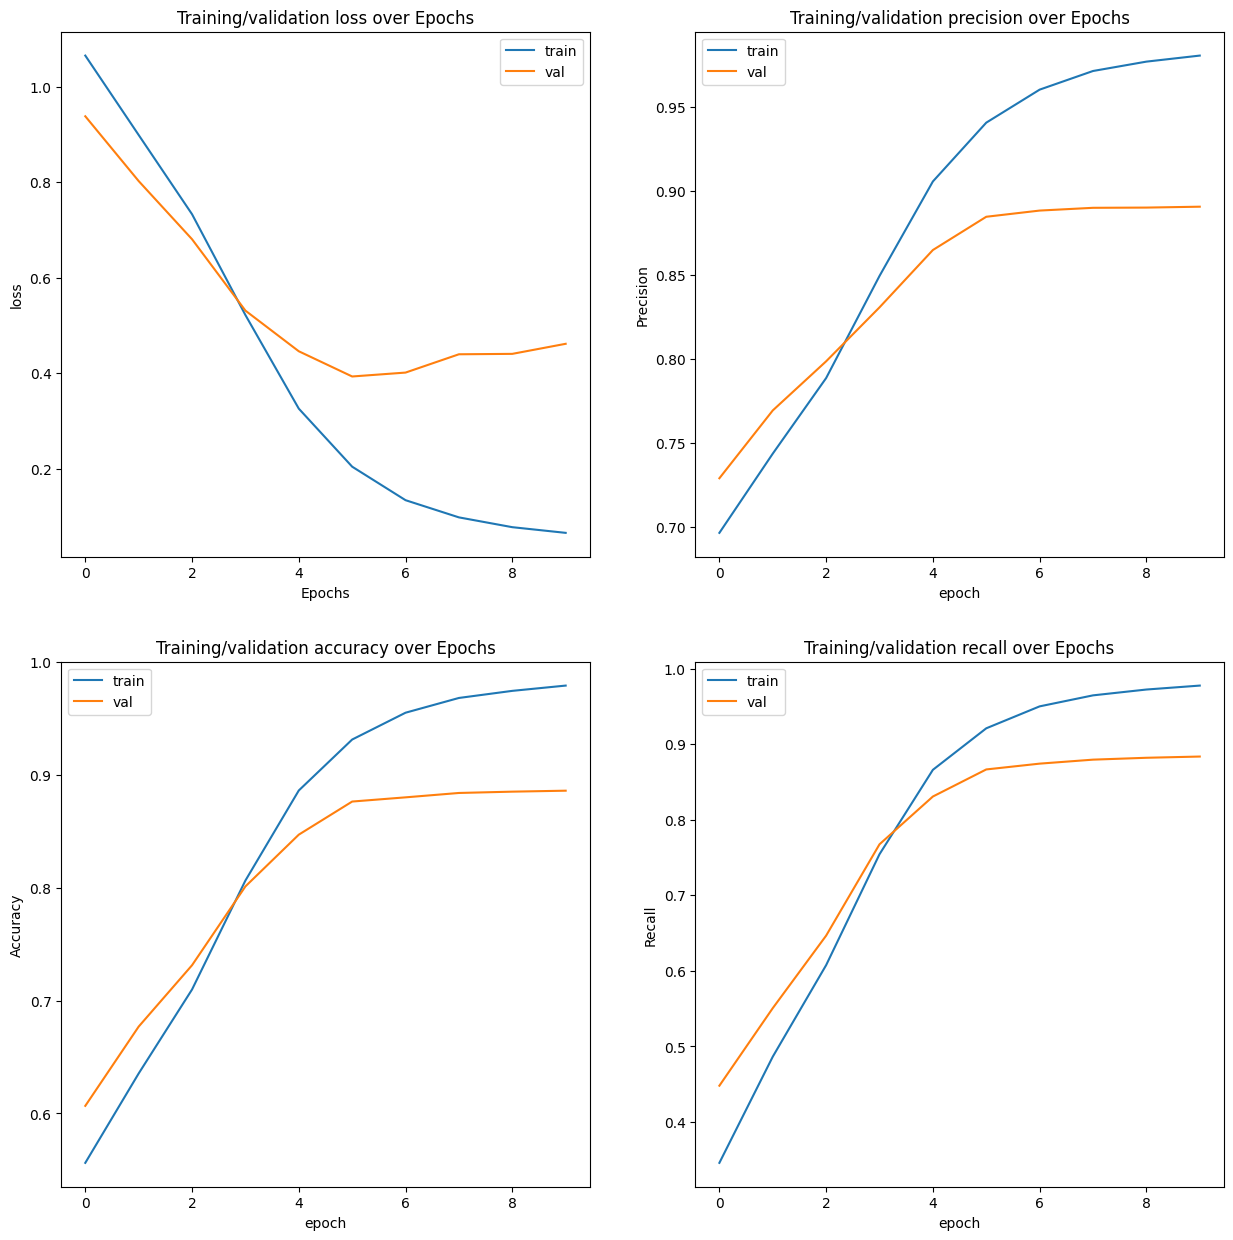

In [27]:
figure , axis = plt.subplots(2,2,figsize=(15,15))


axis[0,0].plot(history.history['loss'] , label='train')
axis[0,0].plot(history.history['val_loss'] , label='val')
axis[0,0].set_title('Training/validation loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('loss')
axis[0,0].legend()


axis[1,0].plot(history.history['accuracy'], label='train')
axis[1,0].plot(history.history['val_accuracy'], label='val')
axis[1,0].set_title('Training/validation accuracy over Epochs')
axis[1,0].set_xlabel('epoch')
axis[1,0].set_ylabel('Accuracy')
axis[1,0].legend()


axis[0,1].plot(history.history['precision'], label='train')
axis[0,1].plot(history.history['val_precision'], label='val')
axis[0,1].set_title('Training/validation precision over Epochs')
axis[0,1].set_xlabel('epoch')
axis[0,1].set_ylabel('Precision')
axis[0,1].legend()


axis[1,1].plot(history.history['recall'], label='train')
axis[1,1].plot(history.history['val_recall'], label='val')
axis[1,1].set_title('Training/validation recall over Epochs')
axis[1,1].set_xlabel('epoch')
axis[1,1].set_ylabel('Recall')
axis[1,1].legend()

In [28]:
test_df = pd.read_csv('twitter_validation.csv')
test_df.columns

Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')

In [29]:
test_df = test_df.drop('3364' , axis=1)
test_df= test_df.rename(columns={"Facebook":"Feature2","I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣":"Feature1","Irrelevant": "labels"})
test_df["tweets"]= test_df["Feature1"].astype(str) +" "+ test_df["Feature2"].astype(str)
test_df= test_df.drop(["Feature1","Feature2"],axis=1)
test_df['tweets'] = test_df.tweets.apply(preprocess)

In [30]:
test_df.head()

,labels,tweets
0,Neutral,bbc news amazon boss jeff bezos rejects clai...
1,Negative,microsoft why do i pay for word when it funct...
2,Negative,csgo matchmaking is so full of closet hacking ...
3,Neutral,now the president is slapping americans in the...
4,Negative,hi eahelp i ve had madeleine mccann in my cel...


In [31]:
test_df['tweet_len'] = [len(text.split()) for text in test_df.tweets]
test_df = test_df[~(test_df['tweet_len'] < 5) & ~(test_df['tweet_len'] > 60)]
x_test = pad_sequences(tokenizer.texts_to_sequences(test_df['tweets'].values) , maxlen=MAXLEN , padding = 'post')
test_labels = lb.fit_transform(test_df['labels'].values)
test_preds = model.predict(x_test).round()

30/30 [==============================] - 4s 88ms/step


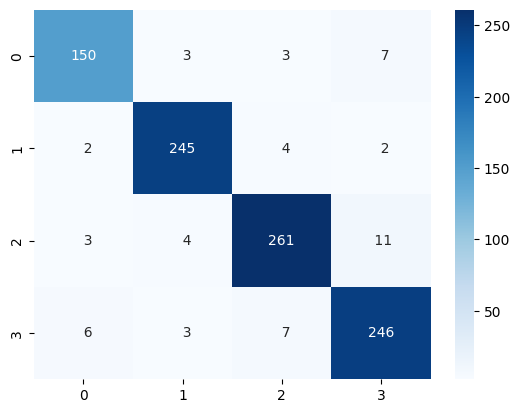

In [32]:
y_preds = []
for i in range(len(test_preds)) : 
    y_preds.append(test_preds[i].argmax())
cm = confusion_matrix(test_labels , y_preds)
sns.heatmap(cm, annot=True,fmt='3g' , cmap="Blues")
plt.show()

In [34]:
def make_predictions(row) : 
    random_data = row.sample(n = 10) 
    random_tweets = random_data['tweets'].values 
    y_test = random_data['labels'].values
    
    x_test = pad_sequences(tokenizer.texts_to_sequences(random_tweets) , maxlen=MAXLEN , padding = 'post')
    
    test_preds = model.predict(x_test).round() 
    
    for i in tqdm(range(10)) : 
        print(f"Tweet : {random_tweets[i]}\n")
        print(f"The original label : {y_test[i]}\n")
        print(f"The prediction is : {getlabel(test_preds[i].argmax())}\n")
        print('-'*120)
        
make_predictions(test_df)

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

Tweet : anyone who thinks that otherwise perfectly quality media can t be ruined by it s message  ethos  or aesthetic needs to sit down and explain why they don t like the call of duty games  especially if they re a shooter fan callofduty

The original label : Negative

The prediction is : Negative

------------------------------------------------------------------------------------------------------------------------
Tweet : congratulations guys finally pubg unban ho gye thnks  zakawaqar  thnks all pubg lover      playerunknownsbattlegrounds pubg 

The original label : Positive

The prediction is : Positive

------------------------------------------------------------------------------------------------------------------------
Tweet :      gets bad flashback in movie theater     realize the witcher was actually good  assassinscreed

The original label : Irrelevant

The prediction is : Irrelevant

-----------------------------------------------------------------------------------------